# Simple DBA Modeling and Implementation 
### Master in Telecommunications Engineering (MET) - Communication Networks (CN)
#### Helena Calatrava, May 2021 (Assignment 5, due to 26/05/2021)

In [184]:
import numpy as np
import pprint # To print dictionaries 'pretty'
import math # for the ceil operation

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle # To plot the results

from collections import OrderedDict # To order dictionaries fast

### 1 - Demand from Keyboard
##### The OLT receives the status of the ONUs

The buffer occupancy reports contain the requested bit rate $R_{L}$ and the traffic contract of the Alloc-ID.

In [195]:
# The ONUs send their activity status to the OLT
# Each dictionary is order according to the time of request (the first one is the earliest request)
# the 'bit_rate' key is linked to the value of the requested bit rate R_{L}
# the 'alloc_id' key contains the Alloc-ID number
# the 'priority' key contains the priority linked to the Alloc-ID's traffic contract type
#the premium contract is linked to high priority (1)
#the standard contract is linked to low priority (0)


#DEMAND 1: EASY
requests = {1: {'bit_rate': 5e6, 'priority' : 0, 'alloc_id' : 9},
          2: {'bit_rate': 30e6, 'priority' : 1, 'alloc_id' : 15},
          3: {'bit_rate': 15e6, 'priority' : 0, 'alloc_id' : 16},
        4: {'bit_rate': 100e6, 'priority' : 1, 'alloc_id' : 444},
          }

"""

#DEMAND 2: REGULAR
requests = {1: {'bit_rate': 60e6, 'priority' : 0, 'alloc_id' : 53},
          2: {'bit_rate': 50e6, 'priority' : 1, 'alloc_id' : 123},
          3: {'bit_rate': 10e6, 'priority' : 0, 'alloc_id' : 124},
        4: {'bit_rate': 60e6, 'priority' : 1, 'alloc_id' : 10},
          }



#DEMAND 3: INSANE
requests = {1: {'bit_rate': 100e6, 'priority' : 1, 'alloc_id' : 1},
          2: {'bit_rate': 100e6, 'priority' : 1, 'alloc_id' : 2},
          3: {'bit_rate': 100e6, 'priority' : 1, 'alloc_id' : 3},
        4: {'bit_rate': 100e6, 'priority' : 1, 'alloc_id' : 4},
            5: {'bit_rate': 100e6, 'priority' : 1, 'alloc_id' : 5},
            6: {'bit_rate': 100e6, 'priority' : 1, 'alloc_id' : 6},
            7: {'bit_rate': 100e6, 'priority' : 1, 'alloc_id' : 7},
            8: {'bit_rate': 100e6, 'priority' : 1, 'alloc_id' : 8},
            9: {'bit_rate': 100e6, 'priority' : 1, 'alloc_id' : 9},
            10: {'bit_rate': 100e6, 'priority' : 1, 'alloc_id' : 10}
            
          }

"""

# Print Results of this Step
pprint.pprint(requests)

{1: {'alloc_id': 1, 'bit_rate': 100000000.0, 'priority': 1},
 2: {'alloc_id': 2, 'bit_rate': 100000000.0, 'priority': 1},
 3: {'alloc_id': 3, 'bit_rate': 100000000.0, 'priority': 1},
 4: {'alloc_id': 4, 'bit_rate': 100000000.0, 'priority': 1},
 5: {'alloc_id': 5, 'bit_rate': 100000000.0, 'priority': 1},
 6: {'alloc_id': 6, 'bit_rate': 100000000.0, 'priority': 1},
 7: {'alloc_id': 7, 'bit_rate': 100000000.0, 'priority': 1},
 8: {'alloc_id': 8, 'bit_rate': 100000000.0, 'priority': 1},
 9: {'alloc_id': 9, 'bit_rate': 100000000.0, 'priority': 1},
 10: {'alloc_id': 10, 'bit_rate': 100000000.0, 'priority': 1}}


##### The traffic load offered by each Alloc-ID is calculated with the information in the demand

### 2 - The DBA calculates the allocation

##### 2.1 - Sort the Requests

In [196]:
# Sort the requests per priority and time of request to get a prioritized sequence of Alloc-IDs
# With the same contract type, requests will be sorted according to the 
#time of request (the earliest, the most priority)
#It is assumed that the order of the requests in the demand dictionary corresponds to the order 
#according to the time of request
sorted_requests = OrderedDict(sorted(requests.items(), key=lambda x: x[1]['priority'], reverse=True))

# Print Results of this Step
print(f'**** SORTED REQUESTS ****')
pprint.pprint(sorted_requests)

**** SORTED REQUESTS ****
OrderedDict([(1, {'alloc_id': 1, 'bit_rate': 100000000.0, 'priority': 1}),
             (2, {'alloc_id': 2, 'bit_rate': 100000000.0, 'priority': 1}),
             (3, {'alloc_id': 3, 'bit_rate': 100000000.0, 'priority': 1}),
             (4, {'alloc_id': 4, 'bit_rate': 100000000.0, 'priority': 1}),
             (5, {'alloc_id': 5, 'bit_rate': 100000000.0, 'priority': 1}),
             (6, {'alloc_id': 6, 'bit_rate': 100000000.0, 'priority': 1}),
             (7, {'alloc_id': 7, 'bit_rate': 100000000.0, 'priority': 1}),
             (8, {'alloc_id': 8, 'bit_rate': 100000000.0, 'priority': 1}),
             (9, {'alloc_id': 9, 'bit_rate': 100000000.0, 'priority': 1}),
             (10, {'alloc_id': 10, 'bit_rate': 100000000.0, 'priority': 1})])


##### 2.2 - Fixed Bandwidth Allocation

In [197]:
# Uplink Capacity
# We have considered that the Upstream GTC frame is 2000 bytes long (instead of 19440) and is sent every 125 us
#Therefore, the upstream bit rate is 128 Mbps instead of 1.24416 Gbps
up_bw = 128e6
frame_length = 125e-6 # in seconds
n_bytes = 2000

# Variables that will be needed to compute the Grant Map
assigned_bw = dict()
final_status = dict()

dict_it = 0 # this variable is needed so that the dictionary keeps sorted as we want

for i in sorted_requests:
    request_i = sorted_requests[i]
    R_L = request_i['bit_rate']
    
    # The assigned fixed BW depends on the traffic contract
    if request_i['priority'] == 0: # Standard Contract
        R_F = 6.5e6
    else: # Premium Contract
        R_F = 20e6
    
    # Initialize the output dictionaries (which will be required to compute the Grant Map)
    assigned_bw[dict_it] = dict()
    assigned_bw[dict_it]['alloc_id'] = request_i['alloc_id']
    
    final_status[dict_it] = dict()
    final_status[dict_it]['alloc_id'] = request_i['alloc_id']
    
    # Check if the remaining uplink bw is enough to supply this fixed BW
    if R_F < up_bw: # we have enough bw
        assigned_bw[dict_it]['assigned_bw'] = R_F
        up_bw = up_bw - R_F
        
        # We prepare the value of the final status just in case the bandwidth
        #is exhausted when allocating the extra bandwidth and we still have not 
        #changed final_status[dict_i]
        if R_L <= R_F: # this request has already been satisfied
            final_status[dict_it]['status'] = 'SUCCESSFUL REQUEST'
        else: #this request could be rejected so we prepare the status just in case
            #if it is finally accepted, the status will be updated
            final_status[dict_it]['status'] = 'REJECTION CASE STUDY 1: No More Available BW'
            
    else: # bw is exhausted in this iteration
        assigned_bw[dict_it]['assigned_bw'] = up_bw
        final_status[dict_it]['status'] = 'REJECTION CASE STUDY 1: No More Available BW'
        up_bw = 0
        
    dict_it = dict_it + 1
    
# Print Results of this Step
print(f'After the Fixed BW Allocation...')
print('\n')
print(f'**** CURRENT BANDWIDTH ALLOCATION DICTIONARY ****')
pprint.pprint(assigned_bw) 
print('\n')
print(f'**** CURRENT STATUS DICTIONARY ****')
print(f'REMEMBER THAT FINAL STATUS AT THIS STAGE IS TEMPORARY (It will be updated 2.3)')
pprint.pprint(final_status)
print('\n')
print(f'Remaining Uplink BW: {up_bw}')
    


After the Fixed BW Allocation...


**** CURRENT BANDWIDTH ALLOCATION DICTIONARY ****
{0: {'alloc_id': 1, 'assigned_bw': 20000000.0},
 1: {'alloc_id': 2, 'assigned_bw': 20000000.0},
 2: {'alloc_id': 3, 'assigned_bw': 20000000.0},
 3: {'alloc_id': 4, 'assigned_bw': 20000000.0},
 4: {'alloc_id': 5, 'assigned_bw': 20000000.0},
 5: {'alloc_id': 6, 'assigned_bw': 20000000.0},
 6: {'alloc_id': 7, 'assigned_bw': 8000000.0},
 7: {'alloc_id': 8, 'assigned_bw': 0},
 8: {'alloc_id': 9, 'assigned_bw': 0},
 9: {'alloc_id': 10, 'assigned_bw': 0}}


**** CURRENT STATUS DICTIONARY ****
REMEMBER THAT FINAL STATUS AT THIS STAGE IS TEMPORARY (It will be updated 2.3)
{0: {'alloc_id': 1, 'status': 'REJECTION CASE STUDY 1: No More Available BW'},
 1: {'alloc_id': 2, 'status': 'REJECTION CASE STUDY 1: No More Available BW'},
 2: {'alloc_id': 3, 'status': 'REJECTION CASE STUDY 1: No More Available BW'},
 3: {'alloc_id': 4, 'status': 'REJECTION CASE STUDY 1: No More Available BW'},
 4: {'alloc_id': 5, 'status':

##### 2.3 - Extra Bandwidth Allocation

In [198]:
if up_bw > 0:
    dict_it = 0 # this variable is needed so that the dictionary keeps sorted as we want

    for i in sorted_requests:
        request_i = sorted_requests[i]
        R_L = request_i['bit_rate']
        
        # The assigned fixed BW depends on the traffic contract
        if request_i['priority'] == 0: # Standard Contract
            R_F = 6.5e6
            R_M = 15e6
        else: # Premium Contract
            R_F = 20e6
            R_M = 60e6
                
                
        if R_L > R_F: # extra BW has been requested

            # Check if the remaining uplink bw is enough to supply the extra BW
            R_E = np.minimum(R_M, R_L) - R_F
            if R_E < up_bw: # we have enough bw

                assigned_bw[dict_it]['assigned_bw'] = np.minimum(R_M, R_L)
                up_bw = up_bw - R_E # R_F has already been subtracted

                # Update the final status for this Alloc-ID
                if R_L <= R_M: # this request has been satisfied
                    final_status[dict_it]['status'] = 'SUCCESSFUL REQUEST'
                else: #The maximum BW has been allocated to this user, but the request was exceeding
                    #the offered traffic load (contract)
                    final_status[dict_it]['status'] = 'REJECTION CASE STUDY 2: MISMATCHING REQUEST'

            else: # bw is exhausted in this iteration   
                
                assigned_bw[dict_it]['assigned_bw'] = assigned_bw[dict_it]['assigned_bw'] + up_bw
                final_status[dict_it]['status'] = 'REJECTION CASE STUDY 1: No More Available BW'
                up_bw = 0
            dict_it = dict_it + 1
            
        else: # no extra BW has been requested
            dict_it = dict_it + 1
            
# Print Results of this Step
print(f'After the Extra BW Allocation...')
print('\n')
print(f'**** FINAL BANDWIDTH ALLOCATION DICTIONARY ****')
pprint.pprint(assigned_bw) 
print('\n')
print(f'**** FINAL STATUS DICTIONARY ****')
pprint.pprint(final_status)
print('\n')
print(f'Remaining Uplink BW: {up_bw}')
        

After the Extra BW Allocation...


**** FINAL BANDWIDTH ALLOCATION DICTIONARY ****
{0: {'alloc_id': 1, 'assigned_bw': 20000000.0},
 1: {'alloc_id': 2, 'assigned_bw': 20000000.0},
 2: {'alloc_id': 3, 'assigned_bw': 20000000.0},
 3: {'alloc_id': 4, 'assigned_bw': 20000000.0},
 4: {'alloc_id': 5, 'assigned_bw': 20000000.0},
 5: {'alloc_id': 6, 'assigned_bw': 20000000.0},
 6: {'alloc_id': 7, 'assigned_bw': 8000000.0},
 7: {'alloc_id': 8, 'assigned_bw': 0},
 8: {'alloc_id': 9, 'assigned_bw': 0},
 9: {'alloc_id': 10, 'assigned_bw': 0}}


**** FINAL STATUS DICTIONARY ****
{0: {'alloc_id': 1, 'status': 'REJECTION CASE STUDY 1: No More Available BW'},
 1: {'alloc_id': 2, 'status': 'REJECTION CASE STUDY 1: No More Available BW'},
 2: {'alloc_id': 3, 'status': 'REJECTION CASE STUDY 1: No More Available BW'},
 3: {'alloc_id': 4, 'status': 'REJECTION CASE STUDY 1: No More Available BW'},
 4: {'alloc_id': 5, 'status': 'REJECTION CASE STUDY 1: No More Available BW'},
 5: {'alloc_id': 6, 'status': 'RE

### 3  - The Grant Map is computed

**** GRANT MAP ****
{0: {'alloc_id': 1, 'start_byte': 0, 'stop_byte': 313},
 1: {'alloc_id': 2, 'start_byte': 314, 'stop_byte': 627},
 2: {'alloc_id': 3, 'start_byte': 628, 'stop_byte': 941},
 3: {'alloc_id': 4, 'start_byte': 942, 'stop_byte': 1255},
 4: {'alloc_id': 5, 'start_byte': 1256, 'stop_byte': 1569},
 5: {'alloc_id': 6, 'start_byte': 1570, 'stop_byte': 1883},
 6: {'alloc_id': 7, 'start_byte': 1884, 'stop_byte': 2000},
 7: {'alloc_id': 8, 'start_byte': 2001, 'stop_byte': 2000},
 8: {'alloc_id': 9, 'start_byte': 2001, 'stop_byte': 2000},
 9: {'alloc_id': 10, 'start_byte': 2001, 'stop_byte': 2000}}


**** FINAL STATUS DICTIONARY ****
{0: {'alloc_id': 1, 'status': 'REJECTION CASE STUDY 1: No More Available BW'},
 1: {'alloc_id': 2, 'status': 'REJECTION CASE STUDY 1: No More Available BW'},
 2: {'alloc_id': 3, 'status': 'REJECTION CASE STUDY 1: No More Available BW'},
 3: {'alloc_id': 4, 'status': 'REJECTION CASE STUDY 1: No More Available BW'},
 4: {'alloc_id': 5, 'status': 'REJEC

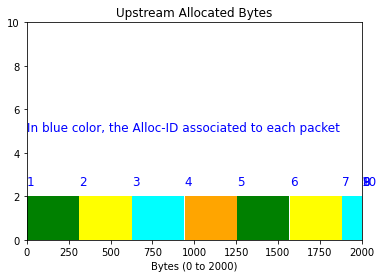

In [199]:
# Variables that will be needed to compute the Grant Map
grant_map= dict()

dict_it = 0 # this variable is needed so that the dictionary keeps sorted as we want
stop_time = -1 # in bytes

# Plot variables
fig, ax = plt.subplots()
plt.xlim([0, n_bytes])
plt.ylim([0, 10])
plt.title('Upstream Allocated Bytes')
plt.xlabel('Bytes (0 to 2000)')
ax.text(0, 5, "In blue color, the Alloc-ID associated to each packet", fontsize=12, color='blue')
color_dict = ['orange', 'green', 'yellow', 'cyan']

for i in assigned_bw:
    grant_i = assigned_bw[i]
    
    # Initialize the Grant Map
    grant_map[dict_it] = dict()
    grant_map[dict_it]['alloc_id'] = grant_i['alloc_id']
    
    # Calculate assigned number of bits
    #in total (taking into account fixed and extra BW)
    bytes_i = grant_i['assigned_bw'] * frame_length / 8 
    bytes_i = math.ceil(bytes_i)
    
    # Update the start and stop time values
    start_time = stop_time + 1
    if start_time + bytes_i < n_bytes: 
        stop_time = start_time + bytes_i
    else: # We will not be able to give all the allocated bytes (we do not consider the possibility to
        #solve this for this assignment)
        stop_time = n_bytes
    grant_map[dict_it]['start_byte'] = start_time
    grant_map[dict_it]['stop_byte'] = stop_time
    
    dict_it = dict_it + 1
    
    # Add the rectangle, which simulated the allocated upstream packet
    ax.add_patch(Rectangle((start_time, 0), stop_time, 2, facecolor = color_dict[np.mod(dict_it,4)]))
    ax.add_patch(Rectangle((stop_time, 0), n_bytes, 2, facecolor = 'white'))
    ax.text(start_time, 2.5, grant_i['alloc_id'], fontsize=12, color='blue')

# The new Grant Map is printed
# Print Results of this Step
print(f'**** GRANT MAP ****')
pprint.pprint(grant_map)
print('\n')
print(f'**** FINAL STATUS DICTIONARY ****')
pprint.pprint(final_status)
